# Введение

В этом соревновании требуется Классифицировать автомобиль по фотографии.

# Подготовка данных, загрузка библиотек и вспомогательных процедур и функций

In [ ]:
# подготавливаем данные

# для Kaggle Kernel
!mkdir /kaggle/temp #папка для временных файлов
!unzip ../input/sf-dl-car-classification/test.zip  -d /kaggle/temp
!unzip ../input/sf-dl-car-classification/train.zip -d /kaggle/temp
sample_submission_path =  '../input/sf-dl-car-classification/sample-submission.csv'
train_path = '/kaggle/temp/train/'
sub_path = '/kaggle/temp/test_upload'

# имена классов
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
] 

# вывести текущую директорию
# print("Текущая деректория:", os.getcwd())

In [ ]:
# импорты

import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import Xception
from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

In [ ]:
def learning_graphic(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    return plt



In [ ]:
def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
  generator = itertools.islice(generator, count)
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()


# Бейзлайн

## Создаем генераторы изображений

In [ ]:
image_size = (90, 120)
batch_size = 32

train_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=0.2,
    # ниже параметры аугментаций:
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2),
)

val_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=0.2,
)

sub_datagen = ImageDataGenerator(
    #rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
# Посмотрим на картинки авто
print('Train:')
show_first_images(train_generator)

print('Val:')
show_first_images(val_generator)

print('Sub:')
show_first_images(sub_generator, labels=False)

In [ ]:
# строим модель
model = Sequential([
  EfficientNetB0(weights='imagenet', input_shape=(*image_size, 3), include_top=False), #предобученная нейросеть из модуля keras.applications
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10)
])

model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)),
    metrics='accuracy'
)

In [ ]:
# обучаем модель
model.fit(train_generator, validation_data=val_generator, epochs=1)

Что мы получили в итоге?

*   Точность на обучающих данных, усредненная по первой эпохе, равна 0.4
*   Точность на валидационных данных в конце первой эпохи равна 0.6

Сделаем файл для сабмита:

In [ ]:
predictions = model.predict(sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': predictions
}, columns=['Id', 'Category'])
submission.to_csv('submission.csv', index=False)

# EDA

In [ ]:
train = pd.read_csv("../input/sf-dl-car-classification/train.csv")
train.info()

In [ ]:
train.head()

In [ ]:
train.Category.value_counts()

In [ ]:
# Посмотрим на сбалансированность целевой переменной
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Category", data=train)
# присутствует некоторая несбалансированность: 

In [ ]:
# сбалансируем данные по категориям
cat_max = int(train.Category.value_counts().max())
# определяем сколько необходимо добавить файлов до максимума в каждой категиории
for delta, cat in zip(cat_max - train.Category.value_counts().values, train.Category.value_counts().index):    
    print(delta, ' ', cat, ' ', )
    if delta == 0:
        continue
    cat_path = train_path + '/' + str(cat) + '/'
    # копируем недостающее до мах количество файлов и дополняем информацию о добавленных файлах в таблице train 
    ind = 0
    for root, directories, files in os.walk(cat_path):
        for file in files:
            file_name = str(ind) + '_' + file
            shutil.copy(cat_path + file, cat_path + file_name)
            train.loc[str(len(train) + 1)] = [file_name, cat] 
            ind += 1
            if ind == delta - 1:
                break


In [ ]:
train.tail()

In [ ]:
# Проверим сбалансированность
ax = sns.countplot(x="Category", data=train)

In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(f'{train_path}{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

# Model parameter set

In [ ]:
EPOCHS               = 9
BATCH_SIZE           = 64
LR                   = 1e-4
VAL_SPLIT            = 0.2

CLASS_NUM            = 10
IMG_SIZE             = 250 
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
RANDOM_SEED          = 42
MODEL                = 'EfficientNetB5'

# import efficientnet.tfkeras as efn

# Augmentation 

In [ ]:
# Установка библиотеки
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor -q

## Основные используемые приемы аугментации данных

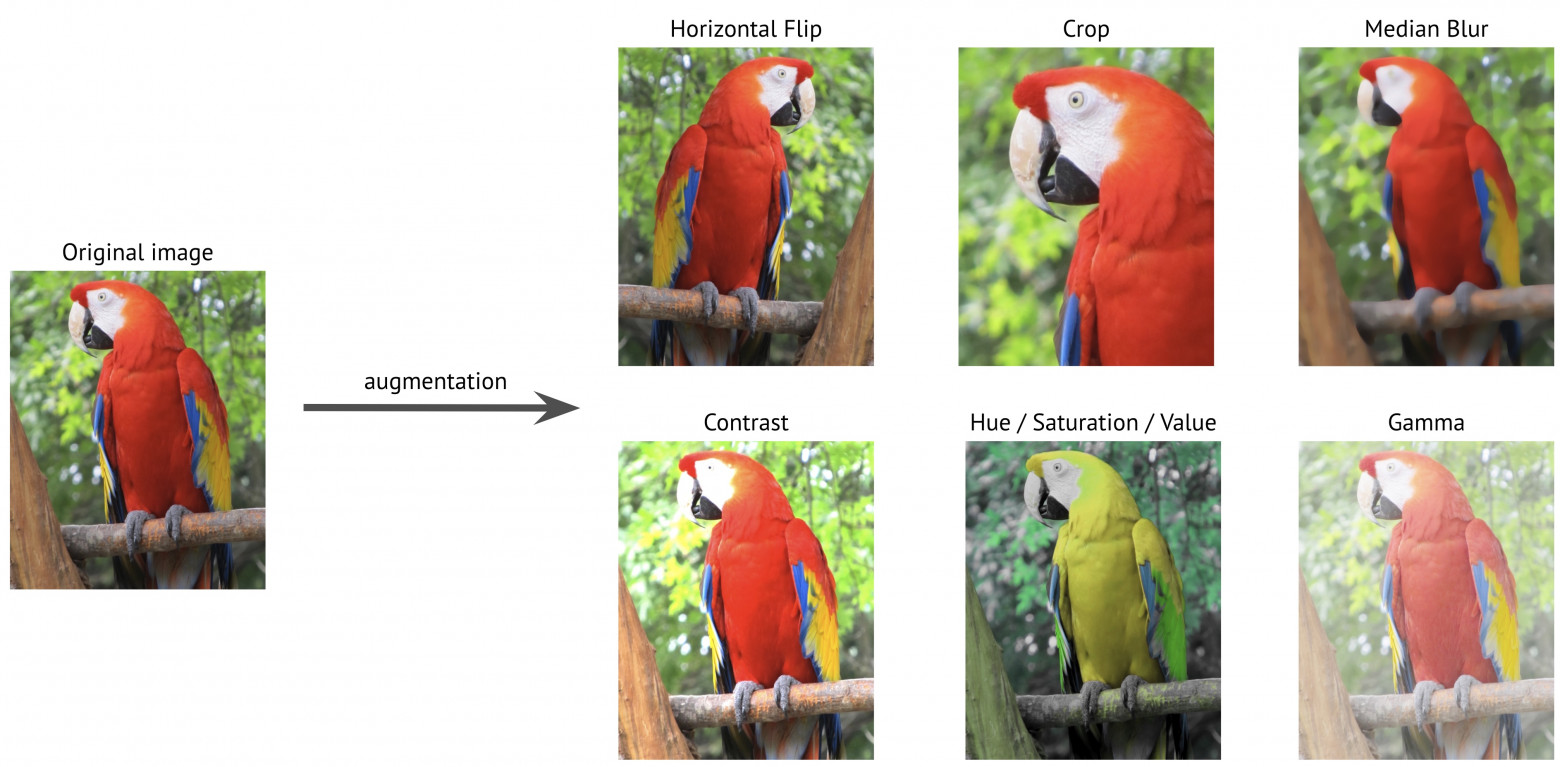

In [ ]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

# Официальная дока https://keras.io/preprocessing/image/
AUGMENTATIONS = albumentations.Compose([

    albumentations.HorizontalFlip(p=0.5),
    albumentations.CoarseDropout(p=1, max_height=18, max_width=18), 

    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
         albumentations.CenterCrop(height=224, width=200),
         albumentations.CenterCrop(height=200, width=224),
    ],p=0.5),

    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.8),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.8),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)

])

train_datagen = ImageDataAugmentor(
        rescale=1/255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

test_datagen = ImageDataGenerator(
    rescale=1/ 255
    )

# Используем аугментацию для данных для submition не дало результат
'''
test_datagen = ImageDataAugmentor(
    rescale=1/ 255,
    augment = AUGMENTATIONS
    )
'''

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # Набор данных для обучения

test_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # Набор данных для валидации

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

In [ ]:
# Посмотрим на картинки авто после аугментации
print('Train:')
show_first_images(train_generator, normalized=True)

print('Val:')
show_first_images(test_generator, normalized=True)

print('Sub:')
show_first_images(test_sub_generator, labels=False, normalized=True)

# Transfer learning
Используем предобученную модель из библиотеки efficientnet

In [ ]:
pip install -U git+https://github.com/qubvel/efficientnet


In [ ]:
import efficientnet.keras as efn 

## Подготовка процедур обратных вызовов

In [ ]:
# https://keras.io/api/callbacks/
def make_callbacks():
   # прекращение обучения в случае прекращения улучшения метрики
   # значение метрики может колебаться в процессе обучения, поэтому иногда стоит продолжить 
   # обучение несмотря на ухудшение метрики
    callback_early_stopping = EarlyStopping(monitor='accuracy',patience=2, verbose=1)
    # уменьшить скорость обучения в случае прекращения улучшения метрики
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,min_lr=1e-10,patience=0,verbose=1)
    # оптимизировать скорость обучения в начале каждой эпохи, исходя из текщей скорости и номера эпохи
    callback_learing_rate = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x),
    # сохранение модели и ее весов в контрольных точках обучения в целях их дальнейшего использования
    path_checkpoint = 'checkpoint.keras'
    callback_checkpoint = ModelCheckpoint(f'{MODEL}_best.hdf5' , monitor = ['val_acc'] , verbose = 1  , mode = 'max') 

    return [callback_checkpoint,
            callback_learing_rate,
                 callback_reduce_lr]

callbacks = make_callbacks()

In [ ]:
base_model = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)
# Заморозим веса EfficientNetB5 и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения
base_model.trainable = False

model = Sequential([ 
    base_model,
    GlobalMaxPool2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(CLASS_NUM, activation='softmax')  
])

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])


In [ ]:
# model.build(input_shape=input_shape)
# сколько слоев
print(len(model.layers))
len(model.trainable_variables)
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

In [ ]:
# Checking the GPU.
!nvidia-smi

In [ ]:
# обучаем модель
history = model.fit(train_generator, 
          steps_per_epoch = len(train_generator),
          validation_data=test_generator, 
          validation_steps = len(test_generator),
          epochs=EPOCHS,
          callbacks=callbacks)

In [ ]:
model.save(f'{MODEL}_last.hdf5')
model.load_weights(f'{MODEL}_best.hdf5')

scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# посмотрим на графики обучения
learning_graphic(history).show()

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = int(len(base_model.layers)/2)

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
# Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)

In [ ]:
len(base_model.trainable_variables)

## Fine tuning

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = int(len(base_model.layers)/2) # увеличим долю зафиксированных слоев до 3/4 /2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

In [ ]:
EPOCHS               = 20  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
callbacks = make_callbacks()

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks
)

In [ ]:
model.save(f'{MODEL}_last.hdf5')
model.load_weights(f'{MODEL}_best.hdf5')

scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# посмотрим на графики обучения
learning_graphic(history).show()

In [ ]:
predictions = model.predict(test_sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame({
    'Id': test_sub_generator.filenames,
    'Category': predictions
}, columns=['Id', 'Category'])


submission.to_csv('submission.csv', index=False)

# Использование тестовых данных для обучения модели

In [ ]:
for root, directories, files in os.walk(train_path):
    print(directories)
    num = 0
    for file in files:
      num += 1
    print(directories, num)

In [ ]:
# скопируем тестовые данные в соответствующие каталоги 
for root, directories, files in os.walk(sub_path):

    for file in files:
        Cat = submission[submission.Id == file]['Category']
        shutil.copy(sub_path + '/' + file, train_path + str(Cat.values[0]) + '/' + file)

print('copied')

In [ ]:
# Проведем аугментацию расширенного сета данных
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1/255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

In [ ]:
# Создадим наборы данных для обучения и валидации
EPOCHS               = 9
BATCH_SIZE           = 64

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # Набор данных для обучения

test_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # Набор данных для валидации

In [ ]:
# Повторим процедуру обучения на расширенных данных

base_model = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

model = Sequential([ 
    base_model,
    GlobalMaxPool2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(CLASS_NUM, activation='softmax')  
])

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

callbacks = make_callbacks()

# обучаем модель
history = model.fit(train_generator, 
          steps_per_epoch = len(train_generator),
          validation_data=test_generator, 
          validation_steps = len(test_generator),
          epochs=EPOCHS,
          callbacks=callbacks)

In [ ]:
model.save(f'{MODEL}_last.hdf5')
model.load_weights(f'{MODEL}_best.hdf5')

scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Fine tuning
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = int(len(base_model.layers)/2) 

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)
    
EPOCHS               = 20  # эпох на обучение

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])
callbacks = make_callbacks()

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks
)

In [ ]:
learning_graphic(history).show()

In [ ]:
predictions = model.predict(test_sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame({
    'Id': test_sub_generator.filenames,
    'Category': predictions
}, columns=['Id', 'Category'])


submission.to_csv('submission.csv', index=False)

# Test-time augmentations (TTA)

In [ ]:
# Сделаем предсказания 5 раз
predictions = []
for _ in range(5):
  predictions.append(model.predict(test_sub_generator, verbose=1))
  test_sub_generator.reset()
predictions = np.array(predictions)
predictions.shape

In [ ]:
# усредним их
final_predictions = predictions.mean(axis=0).argmax(axis=-1)

# и сохраним
submission = pd.DataFrame({
    'Id': test_sub_generator.filenames,
    'Category': final_predictions
}, columns=['Id', 'Category'])


submission.to_csv('submission.csv', index=False)

# Анализ проделанной работы и полученных результатов

На бейзлан была пролучена точность 0,64299.

Перебор версий базовой модели, выбранной в результате анализа данных   для трансферного обучения с использованием тонкой настройки (версии 2-8) дал точность 0,96074.

Псевдо разметка данных сабмишн (версия 10) выигрыша в точности не дала.

Применение аугментации и настройка скорости обучения (версии 12-18) дало максимальную точность 0,96089.

Аугментация при тестировании (версия 19) не привела к повышению точности.

Попытка сбалансироть исходные данные (версия 20) так же не привела к успеху.
